In [1]:
# Import Libraries
library(tidyverse)
require(gridExtra)
require(janitor)

# Regression Libraries
library(tidymodels)

# Plot visual libraries
library(ggrepel)
library(ggtext)
library(RColorBrewer)

# Font libraries
library(showtext)
font_add_google("Lato")
showtext_auto()

set.seed(3145) # Set a seed to that future work is reproducible

session_data <- read_csv("data/sessions.csv") |>
    clean_names() |>
    select(hashed_email:end_time) |>
    mutate(start_time = dmy_hm(start_time)) |>
    mutate(end_time = dmy_hm(end_time)) |>
    mutate(session_length = end_time - start_time)

player_data <- read_csv("data/players.csv") |>
    clean_names() |>
    mutate(gender = factor(gender, levels=c("Male","Female", "Non-binary", "Two-Spirited", "Agender", "Other", "Prefer not to say"))) |>
    mutate(experience = as_factor(experience)) |>
    mutate(subscribe = as_factor(subscribe))

# Merge the player and session data, by connecting the hashed_email variable.
merged_data <- merge(x = session_data, y = player_data, by = "hashed_email") |>
    na.omit() # Remove any missing data.

slice_sample(merged_data, n=10)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: janitor


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.8     ✔ rsample      1.3.0
✔ dials        1.4.0     ✔ tune         1.3.0
✔ infer   

hashed_email,start_time,end_time,session_length,experience,subscribe,played_hours,name,gender,age
<chr>,<dttm>,<dttm>,<drtn>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-06-05 18:24:00,2024-06-05 18:29:00,5 mins,Amateur,TRUE,56.1,Dana,Male,23
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-05-13 20:09:00,2024-05-13 20:37:00,28 mins,Amateur,TRUE,150.0,Delara,Female,16
e74c60a92c0100e7240be56d66969db85856152b048c639331a3595f901461ae,2024-05-29 07:11:00,2024-05-29 07:17:00,6 mins,Beginner,FALSE,7.1,Arash,Male,17
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,2024-08-08 00:03:00,2024-08-08 00:18:00,15 mins,Pro,TRUE,30.3,Morgan,Male,9
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-27 02:18:00,2024-07-27 02:48:00,30 mins,Amateur,TRUE,150.0,Delara,Female,16
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2024-05-23 00:22:00,2024-05-23 01:07:00,45 mins,Regular,TRUE,1.5,Isaac,Male,20
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-06-14 00:08:00,2024-06-14 01:01:00,53 mins,Amateur,TRUE,150.0,Delara,Female,16
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-21 22:23:00,2024-06-21 22:28:00,5 mins,Amateur,TRUE,53.9,Alex,Male,17
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-10 05:46:00,2024-07-10 05:53:00,7 mins,Amateur,TRUE,56.1,Dana,Male,23


In [2]:
# Exploring session start times relative to player age
session_start_vs_time <- merged_data |>
    ggplot(aes(x = (hour(start_time) + minute(start_time) / 60), y = age)) +
    geom_point(alpha = 0.3) +
    labs(
        x = "Session Start Time (24h format)",
        y = "Age of players",
        title = "Session Start Times vs Time of Day"
    )


In [3]:
# Exploring the total users active on the server over a 24 hour period. Idea: Seperate over unique days?

# Get time boundaries
boundaries <- merged_data |>
    summarize(oldest = min(start_time), newest = max(start_time))

# Clean data (we only need the session times)
time_data <- merged_data |>
    select(start_time, end_time) |>
    na.omit()


In [4]:
# Create a sequence of every minute the server was active
time_seq <- seq(boundaries$oldest, boundaries$newest, "min")

# Count active players for each minute
activity_by_min <- tibble(time = time_seq) |>
    rowwise() |>
    mutate(
        count = sum(time_data$start_time <= time & time_data$end_time > time)
    )

activity_plot_data <- activity_by_min |>
    mutate(
        day_of_week = wday(time, label = TRUE, abbr = FALSE),
        time_clock = (hour(time) + minute(time) / 60)
    ) |>
    group_by(day_of_week, time_clock) |>
    mutate(count = mean(count))


In [8]:
options(repr.plot.width = 12)
daily_activity_plot <- activity_plot_data |>
    ggplot(aes(x = time_clock, y = count)) +
    geom_line(aes(color = count)) +
    # geom_smooth(method = "lm", formula = y ~ poly(x,18), color="black") +
    facet_grid(rows = vars(day_of_week)) +
    labs(x = "Time of day (24h format)", y = "Average number of players", title = "Average number of players throughout the day (24h format)", colour = "Average number of players")

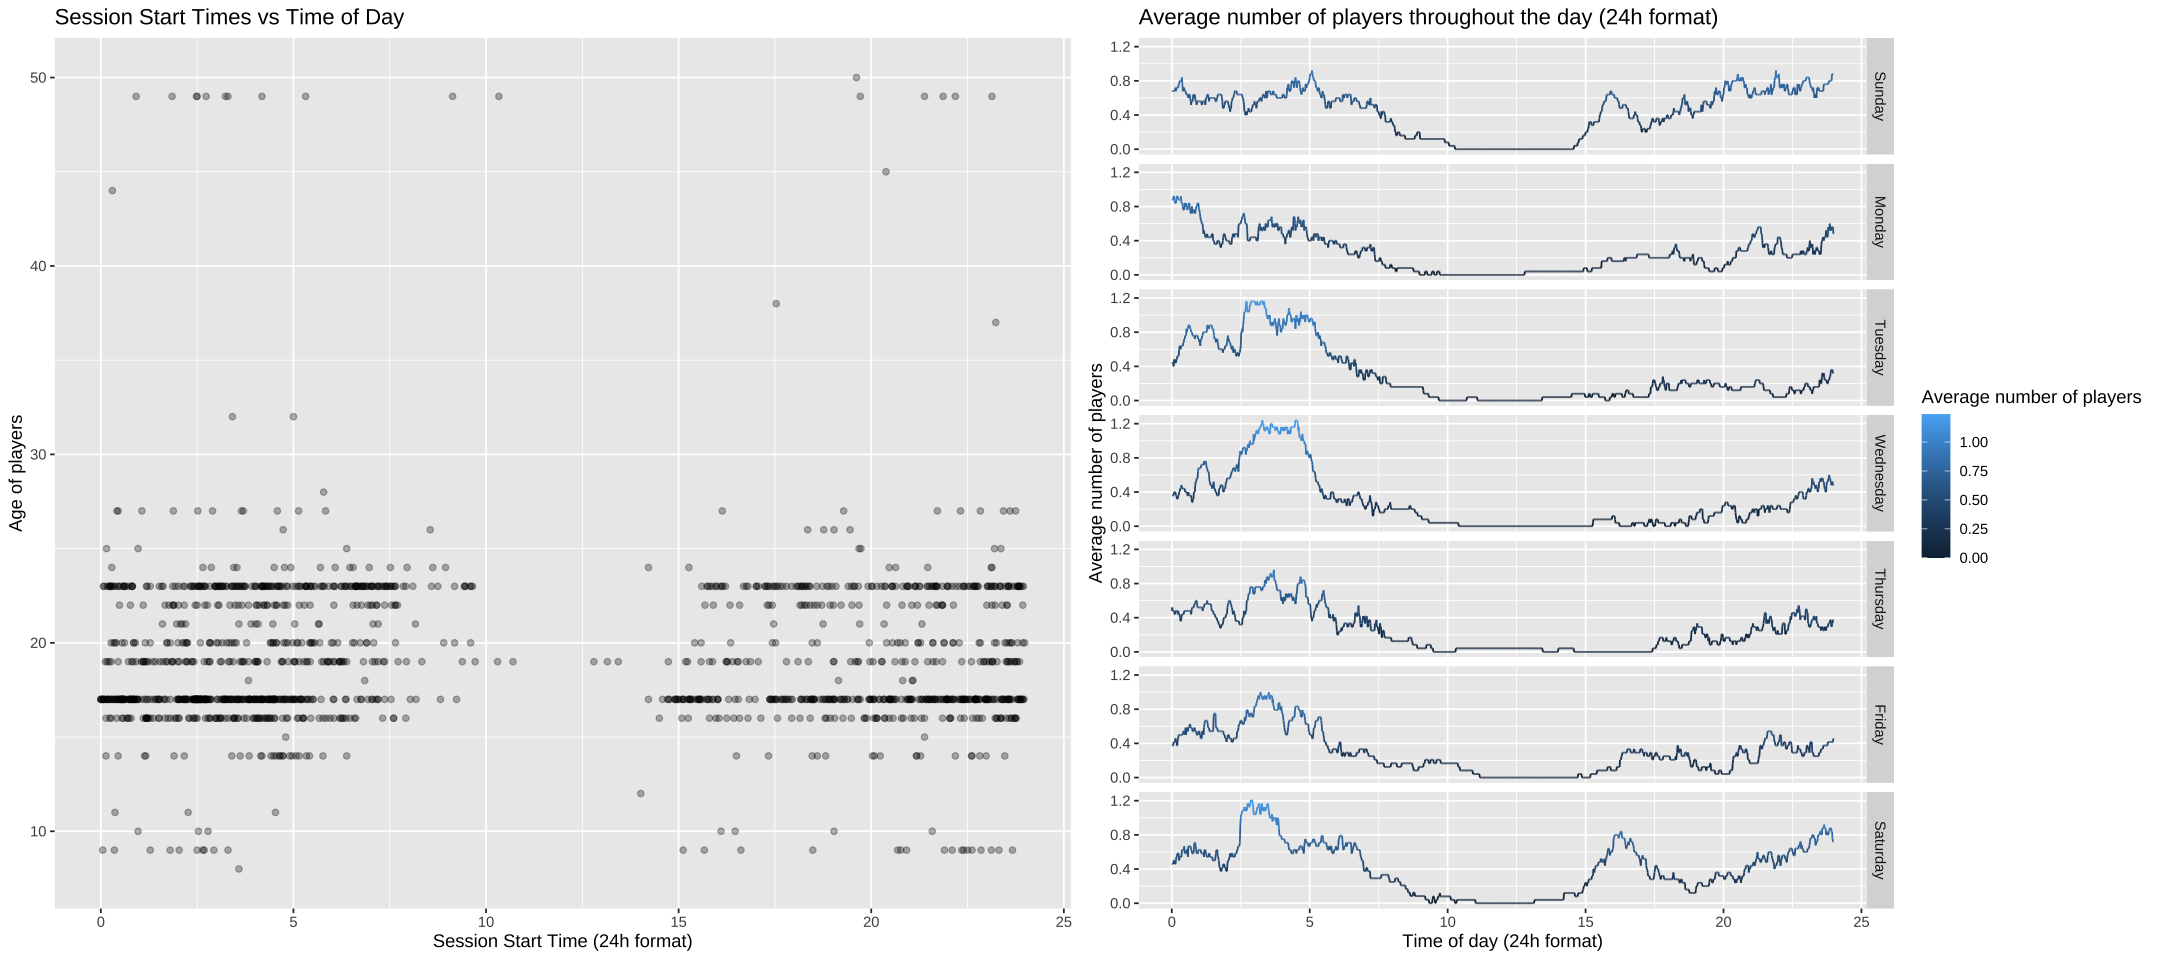

In [6]:
options(repr.plot.width = 18, repr.plot.height = 8)
final_plot <- grid.arrange(session_start_vs_time, daily_activity_plot, ncol = 2)
